In [1]:
from torch_points3d.datasets.base_dataset import BaseDataset
from torch.utils.data import Dataset

In [2]:
import numpy as np
import pandas as pd
import time 
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from torch_geometric.io import read_txt_array
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

from plyfile import PlyData, PlyElement,PlyProperty, PlyListProperty

import sys
from omegaconf import OmegaConf
import pyvista as pv
import ipdb

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 2000)
pd.set_option("display.max_colwidth", 256)

torch.set_printoptions(precision=8)

In [5]:
%matplotlib inline
sns.set(rc={'figure.figsize':(8,6)})


In [6]:
patient_id_list_new =  '2_BC	3_BC	4_BC	5_BM	6_BM	7_BP	8_BP	9_KBW	10_SUM	11_DHM	12_GAW	13_PMM	14_TR	15_TR	16_TR	18_EM	19_EM	20_EM	21_FA	22_FA	23_HJ	24_HJ	25_HM	26_HM	27_HM	28_JM	29_JM	30_JM	31_JM	32_JM	33_KBB	34_KBB	35_KBB	36_KBB	37_KBB	38_KBB	39_KBB	40_KBB	41_KBB	42_KBB	43_KBB	44_AC	45_AC	46_LE	47_LE	48_LE	50_LE	51_LE	52_LE	54_MR	55_MR	56_WA	57_SF	58_SI	59_SI'
patient_id_list_new = patient_id_list_new.split()
patient_id_list_new[:5]

['2_BC', '3_BC', '4_BC', '5_BM', '6_BM']

In [7]:
os.getcwd()

'D:\\Workspace\\Python\\aneurysm-segmentation\\datasets'

In [8]:
DIR = os.getcwd() # Replace with your root directory, the data will go in DIR/data.

In [9]:
shapenet_yaml = """
class: shapenet.ShapeNetDataset
task: segmentation
dataroot: %s
first_subsampling: 0.02                       # Grid size of the input data
pre_transforms:                               # Offline transforms, done only once
    - transform: NormalizeScale           
    - transform: GridSampling3D
      params:
        size: ${first_subsampling}
train_transforms:                             # Data augmentation pipeline
    - transform: RandomNoise
      params:
        sigma: 0.01
        clip: 0.05
    - transform: RandomScaleAnisotropic
      params:
        scales: [0.9,1.1]
    - transform: AddOnes
    - transform: AddFeatsByKeys
      params:
        list_add_to_x: [True]
        feat_names: ["ones"]
        delete_feats: [True]
test_transforms:
    - transform: AddOnes
    - transform: AddFeatsByKeys
      params:
        list_add_to_x: [True]
        feat_names: ["ones"]
        delete_feats: [True]
""" % (os.path.join(DIR,"data")) 

from omegaconf import OmegaConf
params = OmegaConf.create(shapenet_yaml)
# if CATEGORY != "All":
#     params.category = CATEGORY

In [9]:
shapenet_yaml = """
class: shapenet.ShapeNetDataset
task: segmentation
dataroot: %s
first_subsampling: 0.02                       # Grid size of the input data
pre_transforms:                               # Offline transforms, done only once
    - transform: NormalizeScale           
    - transform: GridSampling3D
      params:
        size: ${first_subsampling}
train_transforms:                             # Data augmentation pipeline
    - transform: RandomNoise
      params:
        sigma: 0.01
        clip: 0.05
    - transform: RandomScaleAnisotropic
      params:
        scales: [0.9,1.1]
""" % (os.path.join(DIR,"data")) 

from omegaconf import OmegaConf
params = OmegaConf.create(shapenet_yaml)
# if CATEGORY != "All":
#     params.category = CATEGORY

In [10]:
params.raw_file_identifiers = patient_id_list_new
params.raw_file_identifiers

['2_BC', '3_BC', '4_BC', '5_BM', '6_BM', '7_BP', '8_BP', '9_KBW', '10_SUM', '11_DHM', '12_GAW', '13_PMM', '14_TR', '15_TR', '16_TR', '18_EM', '19_EM', '20_EM', '21_FA', '22_FA', '23_HJ', '24_HJ', '25_HM', '26_HM', '27_HM', '28_JM', '29_JM', '30_JM', '31_JM', '32_JM', '33_KBB', '34_KBB', '35_KBB', '36_KBB', '37_KBB', '38_KBB', '39_KBB', '40_KBB', '41_KBB', '42_KBB', '43_KBB', '44_AC', '45_AC', '46_LE', '47_LE', '48_LE', '50_LE', '51_LE', '52_LE', '54_MR', '55_MR', '56_WA', '57_SF', '58_SI', '59_SI']

In [16]:
SHUFFLED_SPLITS = {
    "train": ['2_BC', '3_BC', '4_BC', '5_BM', '6_BM', '7_BP', '9_KBW', '8_BP', '10_SUM', '11_DHM'],
    "val": ['12_GAW', '13_PMM', '14_TR', '15_TR', '16_TR', '18_EM'],
    "test": ['23_HJ', '24_HJ', '25_HM'],
}
params.shuffled_splits = SHUFFLED_SPLITS
params.shuffled_splits

{'train': ['2_BC', '3_BC', '4_BC', '5_BM', '6_BM', '7_BP', '9_KBW', '8_BP', '10_SUM', '11_DHM'], 'val': ['12_GAW', '13_PMM', '14_TR', '15_TR', '16_TR', '18_EM'], 'test': ['23_HJ', '24_HJ', '25_HM']}

In [11]:
SHUFFLED_SPLITS = {
    "train": ['2_BC', '3_BC', '4_BC', '5_BM', '6_BM', '7_BP' ],
    "val": ['12_GAW', '13_PMM', '14_TR' ],
    "test": ['23_HJ', '24_HJ'],
}
params.shuffled_splits = SHUFFLED_SPLITS
params.shuffled_splits

{'train': ['2_BC', '3_BC', '4_BC', '5_BM', '6_BM', '7_BP'], 'val': ['12_GAW', '13_PMM', '14_TR'], 'test': ['23_HJ', '24_HJ']}

In [50]:
params.features_to_include = {"mean_curvature":1, "gauss_curvature":1, "fpfh":0,
                "shot":1, "rf":0, "ones":0}

In [51]:
category_to_seg = {'aneur': [0,1,2,3,4]
             }

In [52]:
import AneurysmDataset
dataset = AneurysmDataset.AneurysmDataset(params,category_to_seg)
dataset

Processing...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Done!


Dataset: AneurysmDataset 
train_pre_batch_collate_transform = None
val_pre_batch_collate_transform = None
test_pre_batch_collate_transform = None
pre_transform = Compose([
    NormalizeScale(),
    GridSampling3D(grid_size=0.02, quantize_coords=False, mode=mean),
])
test_transform = None
train_transform = Compose([
    RandomNoise(sigma=0.01, clip=0.05),
    RandomScaleAnisotropic([0.9, 1.1]),
])
val_transform = None
inference_transform = Compose([
    NormalizeScale(),
    GridSampling3D(grid_size=0.02, quantize_coords=False, mode=mean),
])
Size of train_dataset = 10
Size of test_dataset = 3
Size of val_dataset = 6
Batch size = None

In [19]:
dataset.test_dataset, dataset.train_dataset

([Aneurysm(3)], Aneurysm(10))

In [20]:
dataset.train_dataset[0]

Data(category=[7623], grid_size=[1], id_scan=[1], origin_id=[7623], pos=[7623, 3], x=[7623, 10], y=[7623])

In [21]:
dataset.test_dataset[0][0]

Data(category=[10063], grid_size=[1], id_scan=[1], origin_id=[10063], pos=[10063, 3], x=[10063, 10], y=[10063])

In [53]:
dataset.train_dataset[0]

Data(category=[7623], grid_size=[1], id_scan=[1], origin_id=[7623], pos=[7623, 3], x=[7623, 5], y=[7623])

In [54]:
dataset.test_dataset[0][0]

Data(category=[10063], grid_size=[1], id_scan=[1], origin_id=[10063], pos=[10063, 3], x=[10063, 5], y=[10063])

In [56]:
cols = [ 'mean_curv', 'gauss_curv','shot_1',
       'shot_2', 'shot_3' ]
train_df = pd.DataFrame(dataset.train_dataset[0].x.numpy(), columns = cols)
train_df.head(10)

,mean_curv,gauss_curv,shot_1,shot_2,shot_3
0,0.615034,0.014545,0.610579,0.349233,0.327272
1,0.567320,0.013973,0.581621,0.300985,0.441860
2,0.503703,0.013347,0.428702,0.094581,0.451043
3,0.621357,0.014567,0.530922,0.122289,0.685312
4,0.523997,0.013481,0.650945,0.298726,0.612216
5,0.488143,0.013208,0.599919,0.314342,0.472449
6,0.538394,0.013663,0.574180,0.226916,0.577248
7,0.500491,0.013294,0.469087,0.380140,0.457523
8,0.485863,0.013217,0.681799,0.411633,0.454261
9,0.485418,0.013105,0.536143,0.303573,0.377540


In [36]:
cols = [ 'mean_curv', 'gauss_curv', 'fpfh_1', 'fpfh_2', 'shot_1',
       'shot_2', 'shot_3', 'rf_1', 'rf_2', 'rf_3', 'FeatOnes']
train_df = pd.DataFrame(dataset.train_dataset[0].x.numpy(), columns = cols)
train_df.head(10)

,mean_curv,gauss_curv,fpfh_1,fpfh_2,shot_1,shot_2,shot_3,rf_1,rf_2,rf_3,FeatOnes
0,0.465563,0.585317,0.895554,0.337046,0.594026,0.386828,0.339832,0.346073,0.529007,0.534867,1.0
1,0.445175,0.515517,0.906230,0.336734,0.388571,0.196154,0.481989,0.492950,0.458008,0.740375,1.0
2,0.443688,0.515477,0.886289,0.309789,0.564566,0.196231,0.370816,0.306328,0.453856,0.471640,1.0
3,0.545775,0.555194,0.890761,0.296380,0.483669,0.112101,0.430083,0.298320,0.737341,0.359861,1.0
4,0.622898,0.402560,0.887061,0.227823,0.551539,0.191549,0.538260,0.262447,0.719982,0.338988,1.0
5,0.527894,0.443902,0.876450,0.223568,0.525692,0.093349,0.421178,0.341682,0.775683,0.445450,1.0
6,0.440059,0.518429,0.891091,0.263439,0.370870,0.130397,0.435926,0.550765,0.621166,0.599254,1.0
7,0.486753,0.513911,0.876582,0.203129,0.544614,0.180271,0.566144,0.348705,0.389699,0.535009,1.0
8,0.504489,0.511455,0.877772,0.152803,0.191459,0.627357,0.433733,0.260143,0.462258,0.330620,1.0
9,0.598137,0.629115,0.897735,0.196772,0.490541,0.192665,0.412599,0.661462,0.071410,0.498488,1.0


In [28]:
#with pre-transform
pd.Series(dataset.train_dataset[0].y.numpy()).value_counts(normalize=True)

1    0.444269
0    0.304759
2    0.216409
3    0.030570
4    0.003992
dtype: float64

In [37]:
#without pre-transform
pd.Series(dataset.train_dataset[0].y.numpy()).value_counts(normalize=True)

1    0.443979
0    0.291991
2    0.220287
3    0.037653
4    0.006090
dtype: float64

In [29]:
#with pre-transform
pd.Series(dataset.train_dataset[0].y.numpy()).value_counts()

1    4229
0    2901
2    2060
3     291
4      38
dtype: int64

In [38]:
#without pre-transform
pd.Series(dataset.train_dataset[0].y.numpy()).value_counts()

1    6780
0    4459
2    3364
3     575
4      93
dtype: int64

In [40]:
#without pre-transform
pd.Series(dataset.test_dataset[0][0].y.numpy()).value_counts(normalize=True)

0    0.623431
1    0.277720
2    0.069608
3    0.020701
4    0.008539
dtype: float64

In [44]:
#with pre-transform
pd.Series(dataset.test_dataset[0][0].y.numpy()).value_counts(normalize=True)

0    0.625101
1    0.276187
2    0.072566
3    0.019147
4    0.006999
dtype: float64

In [39]:
#without pre-transform
pd.Series(dataset.test_dataset[0][0].y.numpy()).value_counts()

0    9637
1    4293
2    1076
3     320
4     132
dtype: int64

In [45]:
#with pre-transform
pd.Series(dataset.test_dataset[0][0].y.numpy()).value_counts()

0    7770
1    3433
2     902
3     238
4      87
dtype: int64

In [46]:
dataset.test_dataset[0][0]

Data(grid_size=[1], id_scan=[1], origin_id=[12430], pos=[12430, 3], x=[12430, 11], y=[12430])

In [20]:
cols = [ 'mean_curv', 'gauss_curv', 'fpfh_1', 'fpfh_2', 'shot_1',
       'shot_2', 'shot_3', 'rf_1', 'rf_2', 'rf_3', 'WSS']
test_df = pd.DataFrame(dataset.test_dataset[0][1].x.numpy(), columns = cols)
test_df.head(10)

,mean_curv,gauss_curv,fpfh_1,fpfh_2,shot_1,shot_2,shot_3,rf_1,rf_2,rf_3,WSS
0,0.574222,0.023021,0.189355,0.179383,0.149294,0.493119,0.384175,0.395875,0.111081,0.669914,1.0
1,0.594986,0.024017,0.155496,0.099852,0.291369,0.286426,0.550478,0.548554,0.457991,0.588103,1.0
2,0.540796,0.022298,0.263481,0.256346,0.343632,0.216385,0.458917,0.597847,0.287536,0.688268,1.0
3,0.566919,0.023278,0.188420,0.201164,0.293386,0.287701,0.427172,0.586290,0.388078,0.560212,1.0
4,0.567656,0.023081,0.170254,0.118173,0.304611,0.290573,0.443130,0.494077,0.327877,0.477753,1.0
5,0.584575,0.023584,0.141270,0.157737,0.245510,0.339080,0.422308,0.374689,0.263666,0.300532,1.0
6,0.525221,0.021717,0.375867,0.293390,0.383967,0.147898,0.652409,0.516362,0.079696,0.782724,1.0
7,0.540077,0.022401,0.283213,0.332647,0.253213,0.370398,0.352965,0.662774,0.366041,0.558571,1.0
8,0.572098,0.022859,0.189898,0.305650,0.233913,0.374696,0.528428,0.599768,0.339225,0.783574,1.0
9,0.547476,0.022596,0.157770,0.317482,0.290400,0.271151,0.670979,0.764838,0.674767,0.489369,1.0


In [61]:
test_df.WSS.unique()

array([1.], dtype=float32)

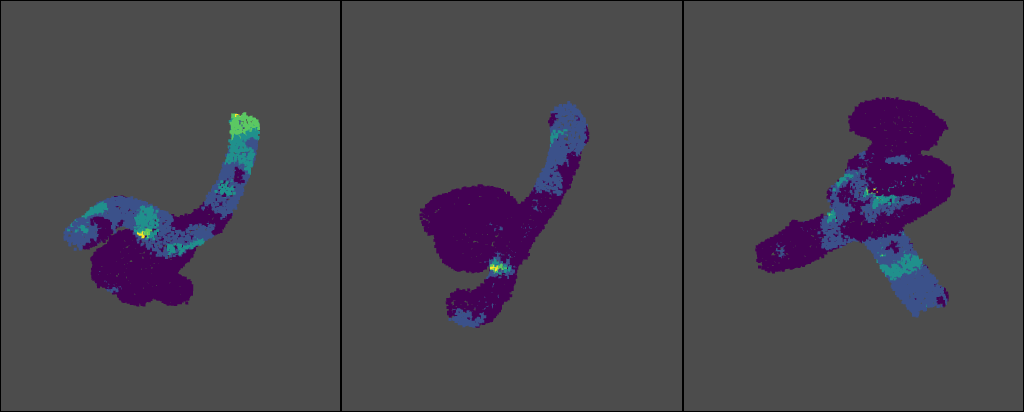

[(0.6793325025732906, -0.21640190482139587, 6.391835305984409),
 (0.05519372224807739, -0.21640190482139587, 0.15044750273227692),
 (0.0, 0.0, 1.0)]

In [20]:
#@title Plot samples with part annotations { run: "auto" }
objectid_1 = 0 #@param {type:"slider", min:0, max:100, step:1}
objectid_2 = 1 #@param {type:"slider", min:0, max:100, step:1}
objectid_3 = 2 #@param {type:"slider", min:0, max:100, step:1}

samples = [objectid_1,objectid_2,objectid_3]
p = pv.Plotter(notebook=True,shape=(1, len(samples)),window_size=[1024,412])
for i in range(len(samples)):
    p.subplot(0, i)
    sample = dataset.train_dataset[samples[i]]
    point_cloud = pv.PolyData(sample.pos.numpy())
    point_cloud['y'] = sample.y.numpy()
    p.add_points(point_cloud,  show_scalar_bar=False, point_size=3)
    p.camera_position = [10,-0, 100]
p.show()

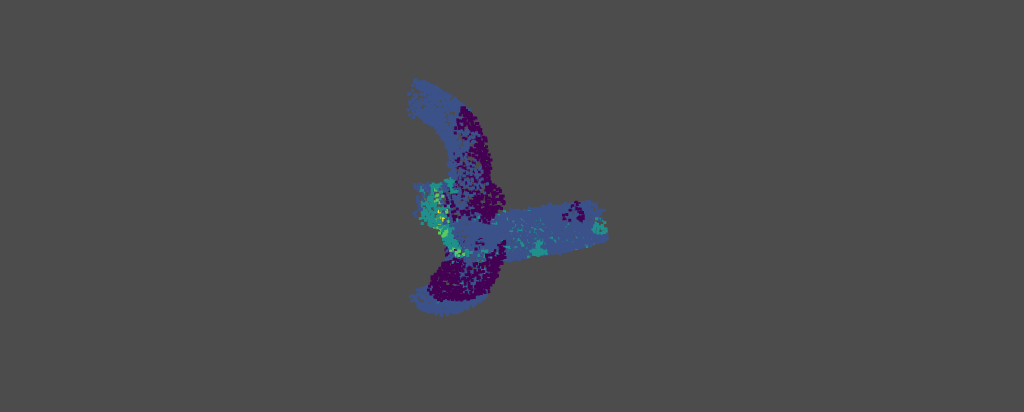

[(0.18299686055221823, -4.962870263851417, 0.2021503363136318),
 (0.1288345754146576, 0.18254682421684265, 0.14798805117607117),
 (0.0, 0.0, 1.0)]

In [31]:
#@title Plot samples with part annotations { run: "auto" }
objectid_1 = 4 #@param {type:"slider", min:0, max:100, step:1}
# objectid_2 = 1 #@param {type:"slider", min:0, max:100, step:1}
# objectid_3 = 2 #@param {type:"slider", min:0, max:100, step:1}

samples = [objectid_1]
p = pv.Plotter(notebook=True,shape=(1, len(samples)),window_size=[1024,412])
for i in range(len(samples)):
    p.subplot(0, i)
    sample = dataset.train_dataset[samples[i]]
    point_cloud = pv.PolyData(sample.pos.numpy())
    point_cloud['y'] = sample.y.numpy()
    p.add_points(point_cloud,  show_scalar_bar=False, point_size=3)
    p.camera_position = [10,-95, 10]
p.show()

## Model for part segmentation
Let's start by creating a multihead segmentation module with one segmentation head per category. We provide that as part of Torch Points3D but let's reproduce it here for sake of completeness.

In [22]:
from torch_points3d.core.common_modules import MLP, UnaryConv

class MultiHeadClassifier(torch.nn.Module):
    """ Allows segregated segmentation in case the category of an object is known. 
    This is the case in ShapeNet for example.

    Parameters
    ----------
    in_features -
        size of the input channel
    cat_to_seg
        category to segment maps for example:
        {
            'Airplane': [0,1,2],
            'Table': [3,4]
        }

    """

    def __init__(self, in_features, cat_to_seg, dropout_proba=0.5, bn_momentum=0.1):
        super().__init__()
        self._cat_to_seg = {}
        self._num_categories = len(cat_to_seg) #2
        self._max_seg_count = 0
        self._max_seg = 0
        self._shifts = torch.zeros((self._num_categories,), dtype=torch.long)
        for i, seg in enumerate(cat_to_seg.values()): #2 times for 2 keys
            self._max_seg_count = max(self._max_seg_count, len(seg)) #overwriting every ith time
            self._max_seg = max(self._max_seg, max(seg))
            self._shifts[i] = min(seg)
            self._cat_to_seg[i] = seg

        self.channel_rasing = MLP(
            [in_features, self._num_categories * in_features], bn_momentum=bn_momentum, bias=False
        )
        if dropout_proba:
            self.channel_rasing.add_module("Dropout", torch.nn.Dropout(p=dropout_proba))

        self.classifier = UnaryConv((self._num_categories, in_features, self._max_seg_count))
        self._bias = torch.nn.Parameter(torch.zeros(self._max_seg_count,))

    def forward(self, features, category_labels, **kwargs):
        assert features.dim() == 2
        self._shifts = self._shifts.to(features.device)
        in_dim = features.shape[-1]
        features = self.channel_rasing(features)
        features = features.reshape((-1, self._num_categories, in_dim))
        features = features.transpose(0, 1)  # [num_categories, num_points, in_dim]
        features = self.classifier(features) + self._bias  # [num_categories, num_points, max_seg]
        ind = category_labels.unsqueeze(-1).repeat(1, 1, features.shape[-1]).long()

        logits = features.gather(0, ind).squeeze(0)
        softmax = torch.nn.functional.log_softmax(logits, dim=-1)

        output = torch.zeros(logits.shape[0], self._max_seg + 1).to(features.device)
        cats_in_batch = torch.unique(category_labels)
        for cat in cats_in_batch:
            cat_mask = category_labels == cat
            seg_indices = self._cat_to_seg[cat.item()]
            probs = softmax[cat_mask, : len(seg_indices)]
            output[cat_mask, seg_indices[0] : seg_indices[-1] + 1] = probs
        
        return output

The model we implement here follows the main architecture proposed in the [original paper](https://arxiv.org/abs/1904.08889):

<p align="center">
  <img width="70%" src="https://drive.google.com/uc?export=view&id=1CJppQ88T69whjYsJc016L3_E_rtcJ8n1" />
</p>

In [57]:
from torch_points3d.applications.kpconv import KPConv


class PartSegKPConv(torch.nn.Module):
    def __init__(self, cat_to_seg):
        super().__init__()
        self.unet = KPConv(
            architecture="unet", 
            input_nc= 4, 
            num_layers=4, 
            in_grid_size=0.02
            )
        self.classifier = MultiHeadClassifier(self.unet.output_nc, cat_to_seg)
    
    @property
    def conv_type(self):
        """ This is needed by the dataset to infer which batch collate should be used"""
        return self.unet.conv_type
    
    def get_batch(self):
        return self.batch
    
    def get_output(self):
        """ This is needed by the tracker to get access to the ouputs of the network"""
        return self.output
    
    def get_labels(self):
        """ Needed by the tracker in order to access ground truth labels"""
        return self.labels
    
    def get_current_losses(self):
        """ Entry point for the tracker to grab the loss """
        return {"loss_seg": float(self.loss_seg)}

    def forward(self, data):
        self.labels = data.y
        self.batch = data.batch
        
        # Forward through unet and classifier
        data_features = self.unet(data)
        self.output = self.classifier(data_features.x, data.category)

         # Set loss for the backward pass
        self.loss_seg = torch.nn.functional.nll_loss(self.output, self.labels)
        return self.output

    def get_spatial_ops(self):
        return self.unet.get_spatial_ops()
        
    def backward(self):
         self.loss_seg.backward() 

    

In [47]:
# cat_to_seg = {'aneur': [0,1,2,3,4]
#              }
# model = PartSegKPConv(cat_to_seg)

In [58]:
model = PartSegKPConv(dataset.class_to_segments)

## The data loaders and CPU pre computing features
KPConv is quite demanding on spatial operations such as grid sampling and radius search. On the network loaded here we have 10 KPConv layers on the encoder which means 10 radius search operations with varying number of neighbours. We observed a significant performance gain by moving those operations to the CPU where they can easily be optimised with suitable data structures such as kd-tree. We use [nonaflann](https://github.com/jlblancoc/nanoflann) in the back-end, a 3D optimised kd-tree implementation. Note that this is beneficiary only if you have access to multiple CPU threads.

You can decide to precompute those spatial operations by setting the `precompute_multi_scale` parameter to `True` when creating the data loaders. The dataset will mine the model to figure out which spatial operations are required and in which order.

In [59]:
NUM_WORKERS = 2
BATCH_SIZE = 3 
dataset.create_dataloaders(
    model,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS, 
    shuffle=True, 
    precompute_multi_scale=True 
    )

In [60]:
sample = next(iter(dataset.train_dataloader))
sample.keys

['x',
 'y',
 'pos',
 'multiscale',
 'upsample',
 'batch',
 'category',
 'grid_size',
 'id_scan',
 'origin_id']

Our `sample` contains the pre computed spatial information in the `multiscale` (encoder side) and `upsample` (decoder) attrivutes. The decoder pre computing is quite simple and just involves some basic caching for the nearest neighbour interpolation operation. Let's take a look at the encoder side of things first. 

In [27]:
sample.multiscale

[Batch(batch=[26721], idx_neighboors=[26721, 25], pos=[26721, 3]),
 Batch(batch=[26721], idx_neighboors=[26721, 25], pos=[26721, 3]),
 Batch(batch=[9876], grid_size=[3], idx_neighboors=[9876, 25], pos=[9876, 3]),
 Batch(batch=[9876], idx_neighboors=[9876, 25], pos=[9876, 3]),
 Batch(batch=[2220], grid_size=[3], idx_neighboors=[2220, 25], pos=[2220, 3]),
 Batch(batch=[2220], idx_neighboors=[2220, 25], pos=[2220, 3]),
 Batch(batch=[520], grid_size=[3], idx_neighboors=[520, 25], pos=[520, 3]),
 Batch(batch=[520], idx_neighboors=[520, 25], pos=[520, 3]),
 Batch(batch=[129], grid_size=[3], idx_neighboors=[129, 25], pos=[129, 3]),
 Batch(batch=[129], idx_neighboors=[129, 25], pos=[129, 3])]

In [61]:
sample.multiscale

[Batch(batch=[28038], idx_neighboors=[28038, 25], pos=[28038, 3]),
 Batch(batch=[28038], idx_neighboors=[28038, 25], pos=[28038, 3]),
 Batch(batch=[10998], grid_size=[3], idx_neighboors=[10998, 25], pos=[10998, 3]),
 Batch(batch=[10998], idx_neighboors=[10998, 25], pos=[10998, 3]),
 Batch(batch=[2551], grid_size=[3], idx_neighboors=[2551, 25], pos=[2551, 3]),
 Batch(batch=[2551], idx_neighboors=[2551, 25], pos=[2551, 3]),
 Batch(batch=[616], grid_size=[3], idx_neighboors=[616, 25], pos=[616, 3]),
 Batch(batch=[616], idx_neighboors=[616, 25], pos=[616, 3]),
 Batch(batch=[135], grid_size=[3], idx_neighboors=[135, 25], pos=[135, 3]),
 Batch(batch=[135], idx_neighboors=[135, 25], pos=[135, 3])]

`sample.multiscale` contains 10 different versions of the input batch, each one of these versions contains the location of the points in `pos` as well as the neighbours of these points in the previous point cloud. We will first look at the points coming out of each downsampling layer (strided convolution), we have 5 of them.

## Training loop

In [28]:
from tqdm.auto import tqdm
import time

class Trainer:
    def __init__(self,model, dataset, num_epoch = 5, device=torch.device('cpu')):
        self.num_epoch = num_epoch
        self._model = model
        self._dataset=dataset
        self.device = device

    def fit(self):
        self.optimizer = torch.optim.Adam(self._model.parameters(), lr=0.001)
        self.tracker = self._dataset.get_tracker(False, True)

        for i in range(self.num_epoch):
            print("=========== EPOCH %i ===========" % i)
            time.sleep(0.5)
            self.train_epoch()
            self.tracker.publish(i)
            self.test_epoch()
            self.tracker.publish(i)

    def train_epoch(self):
        self._model.to(self.device)
        self._model.train()
        self.tracker.reset("train")
        train_loader = self._dataset.train_dataloader
        iter_data_time = time.time()
        with tqdm(train_loader) as tq_train_loader:
            for i, data in enumerate(tq_train_loader):
                t_data = time.time() - iter_data_time
                iter_start_time = time.time()
                self.optimizer.zero_grad()
                data.to(self.device)
                self._model.forward(data)
                self._model.backward()
                self.optimizer.step()
                if i % 10 == 0:
                    self.tracker.track(self._model)

                tq_train_loader.set_postfix(
                    **self.tracker.get_metrics(),
                    data_loading=float(t_data),
                    iteration=float(time.time() - iter_start_time),
                )
                iter_data_time = time.time()

    def test_epoch(self):
        self._model.to(self.device)
        self._model.eval()
        self.tracker.reset("test")
        test_loader = self._dataset.test_dataloaders[0]
        iter_data_time = time.time()
        with tqdm(test_loader) as tq_test_loader:
            for i, data in enumerate(tq_test_loader):
                t_data = time.time() - iter_data_time
                iter_start_time = time.time()
                data.to(self.device)
                self._model.forward(data)           
                self.tracker.track(self._model)

                tq_test_loader.set_postfix(
                    **self.tracker.get_metrics(),
                    data_loading=float(t_data),
                    iteration=float(time.time() - iter_start_time),
                )
                iter_data_time = time.time()

In [29]:
trainer = Trainer(model, dataset)

In [49]:
trainer.fit()

=========== EPOCH 0 ===========


  0%|          | 0/4 [00:10<?, ?it/s]

  0%|          | 0/1 [00:11<?, ?it/s]

=========== EPOCH 1 ===========


  0%|          | 0/4 [00:10<?, ?it/s]

  0%|          | 0/1 [00:10<?, ?it/s]

=========== EPOCH 2 ===========


  0%|          | 0/4 [00:10<?, ?it/s]

  0%|          | 0/1 [00:10<?, ?it/s]

=========== EPOCH 3 ===========


  0%|          | 0/4 [00:10<?, ?it/s]

  0%|          | 0/1 [00:10<?, ?it/s]

=========== EPOCH 4 ===========


  0%|          | 0/4 [00:10<?, ?it/s]

  0%|          | 0/1 [00:10<?, ?it/s]

In [24]:
trainer.fit()

=========== EPOCH 0 ===========


  0%|          | 0/4 [00:11<?, ?it/s]

  0%|          | 0/1 [00:11<?, ?it/s]

=========== EPOCH 1 ===========


  0%|          | 0/4 [00:10<?, ?it/s]

  0%|          | 0/1 [00:09<?, ?it/s]

=========== EPOCH 2 ===========


  0%|          | 0/4 [00:11<?, ?it/s]

  0%|          | 0/1 [00:10<?, ?it/s]

In [30]:
trainer.fit()

=========== EPOCH 0 ===========


  0%|          | 0/4 [00:12<?, ?it/s]

  0%|          | 0/1 [00:09<?, ?it/s]

=========== EPOCH 1 ===========


  0%|          | 0/4 [00:09<?, ?it/s]

  0%|          | 0/1 [00:09<?, ?it/s]

=========== EPOCH 2 ===========


  0%|          | 0/4 [00:09<?, ?it/s]

  0%|          | 0/1 [00:09<?, ?it/s]

=========== EPOCH 3 ===========


  0%|          | 0/4 [00:10<?, ?it/s]

  0%|          | 0/1 [00:09<?, ?it/s]

=========== EPOCH 4 ===========


  0%|          | 0/4 [00:10<?, ?it/s]

  0%|          | 0/1 [00:11<?, ?it/s]

In [62]:
#WIth curvature features
trainer.fit()

=========== EPOCH 0 ===========


  0%|          | 0/4 [00:09<?, ?it/s]

  0%|          | 0/1 [00:09<?, ?it/s]

=========== EPOCH 1 ===========


  0%|          | 0/4 [00:10<?, ?it/s]

  0%|          | 0/1 [00:09<?, ?it/s]

=========== EPOCH 2 ===========


  0%|          | 0/4 [00:09<?, ?it/s]

  0%|          | 0/1 [00:09<?, ?it/s]

=========== EPOCH 3 ===========


  0%|          | 0/4 [00:10<?, ?it/s]

  0%|          | 0/1 [00:10<?, ?it/s]

=========== EPOCH 4 ===========


  0%|          | 0/4 [00:09<?, ?it/s]

  0%|          | 0/1 [00:10<?, ?it/s]

In [25]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/version_4/ # Change for your log location

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 14152.

In [34]:
tensor1 = torch.randn(10, 3, 4)
tensor2 = torch.randn(10, 5, 5)


In [35]:
torch.matmul(tensor1, tensor2).size()

RuntimeError: Expected batch2_sizes[0] == bs && batch2_sizes[1] == contraction_size to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)